## Transfer Learning with TensorFlow Part 1 : Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture which has alreday learned patterns similar to our own, then we can adapt those patterns to our data.

In [ ]:
# Are we using a GPU ?
!nvidia-smi

Sat Aug  3 05:43:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Downloading and becoming one with the data

In [ ]:
# Get data (10% of 10 food classes from Food101)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2024-08-03 05:43:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.141.207, 142.251.2.207, 74.125.137.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   159MB/s    in 1.0s    

2024-08-03 05:43:57 (159 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
# How many images in each folder ?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.17.0


In [ ]:
!pip uninstall tensorflow

Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.17.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
Y
  Successfully uninstalled tensorflow-2.17.0


In [ ]:
!pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

## Create data loaders (preparing the data)

We'll use the ImageDataGenerator class along with the flow_from_directory method to load in our images.

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking experiments witht the TensorBoard callback
* Model checkpoint with the ModelCheckpoint callback
* Stopping a model from training to prevent overfitting with the EarlyStopping callback

In [ ]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like.

The `log_dir` parameter we've created above is only one option.

## Creating models using TensorFlow hub

In the past we've used TensorFlow to create our own models layer by layer form scratch.

Now we're going to do a similar process, except the majority of our model's layers are going to come from TensorFlow Hub.

We can access pretrained models on : https://tfhub.dev/

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link : https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1

In [ ]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model

### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [ ]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# Let's fit our Resnet model to the data ( 10 perecnt of 10 classes)
resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5, steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240803-054431
Epoch 1/5
24/24 [==============================] - 23s 637ms/step - loss: 1.8622 - accuracy: 0.3720 - val_loss: 1.1817 - val_accuracy: 0.6212
Epoch 2/5
24/24 [==============================] - 12s 528ms/step - loss: 0.8787 - accuracy: 0.7347 - val_loss: 0.8287 - val_accuracy: 0.7384
Epoch 3/5
24/24 [==============================] - 13s 550ms/step - loss: 0.5990 - accuracy: 0.8293 - val_loss: 0.7477 - val_accuracy: 0.7564
Epoch 4/5
24/24 [==============================] - 13s 557ms/step - loss: 0.4571 - accuracy: 0.8880 - val_loss: 0.6826 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 12s 523ms/step - loss: 0.3711 - accuracy: 0.9160 - val_loss: 0.6684 - val_accuracy: 0.7776


Wow !

That.Is.Incredible. Our transfer learning feature extraction model outperforms ALL of the previous models we built by hand...(substantially) and in a quicker training time AND with only 10% of the training examples.

In [ ]:
# Let's create a function to plot the loss curves
# Tidbit: you could put a function like this into a script like "helper.py" and import it when you need it...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

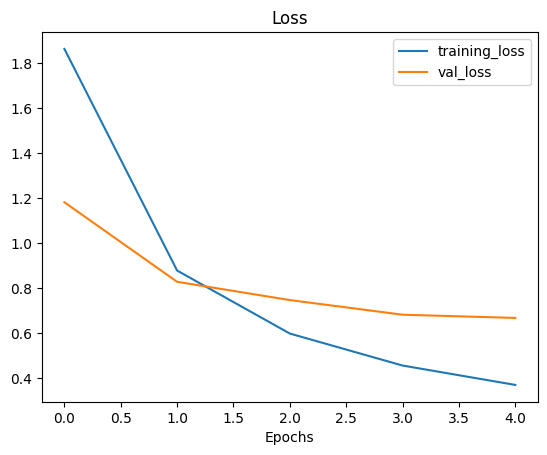

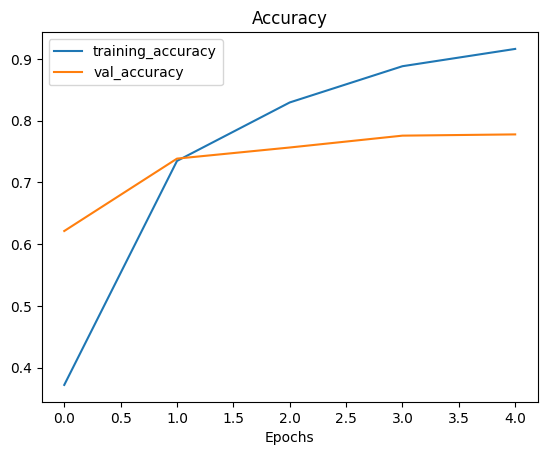

In [ ]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow Hub Feature Extraction model

In [ ]:
# Create model
effnet_model = create_model(efficientnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
effnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Let's fit our effnet model to the data ( 10 perecnt of 10 classes)
effnet_history = effnet_model.fit(train_data_10_percent,
                                  epochs=5, steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="effnetB0"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/effnetB0/20240803-055736
Epoch 1/5
24/24 [==============================] - 28s 720ms/step - loss: 1.9332 - accuracy: 0.3893 - val_loss: 1.3665 - val_accuracy: 0.6964
Epoch 2/5
24/24 [==============================] - 13s 542ms/step - loss: 1.0984 - accuracy: 0.7640 - val_loss: 0.8997 - val_accuracy: 0.8112
Epoch 3/5
24/24 [==============================] - 13s 542ms/step - loss: 0.7712 - accuracy: 0.8413 - val_loss: 0.7172 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 13s 541ms/step - loss: 0.6182 - accuracy: 0.8773 - val_loss: 0.6260 - val_accuracy: 0.8500
Epoch 5/5
24/24 [==============================] - 10s 446ms/step - loss: 0.5201 - accuracy: 0.9013 - val_loss: 0.5702 - val_accuracy: 0.8572


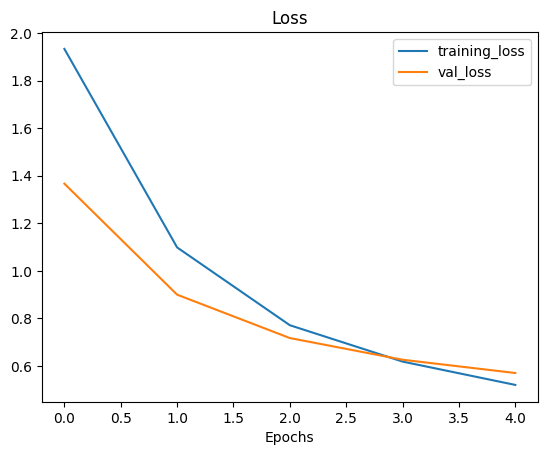

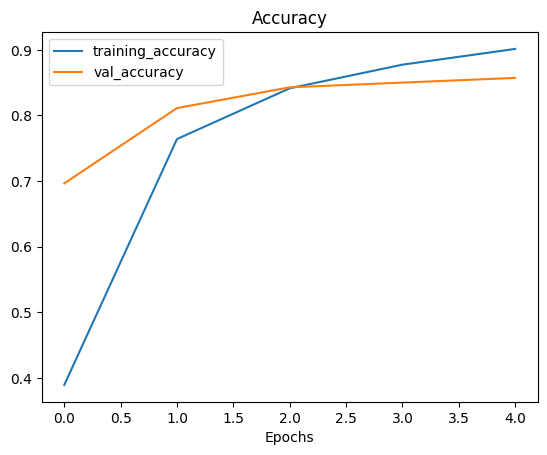

In [ ]:
plot_loss_curves(effnet_history)

In [ ]:
effnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4062374 (15.50 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
# How many layers does our effnetB0 feature extractor have ?
len(effnet_model.layers[0].weights)

309

## Different types of transfer learning

* **"As is" transfer learning** - using an existing model with no changes what so ever (eg: using Imagenet model on 1000 of Imagenet classes , none of which is our own data)
* **"Feature extraction" transfer learning** - use the prelearned patterns of an existing model (eg: EfficientNet B0 trained on ImageNet) and adjust the output layer for our own problem (eg: 1000 classes -> 10 classes of food)
* **"Fine-tuning" transfer learning** - use the prelearned patterns of an existing model and "fine-tune" many or all underlying layers (including new output layers)

## Comparing our models results using TensorBoard

>🔑**Note:** When you upload things to TensorBoard.dev, your experiments are public. So if you're running private experiments (things you don't want other to see) do not upload them to TensorBoard.dev.

In [ ]:
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "effnetB0 vs resnet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of 10 food classes (training data)" \
  --one_shot

2024-08-03 06:44:24.929019: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 06:44:24.929072: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 06:44:24.930326: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 06:44:25.945508: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
****************************************************************
****************************************************************
****************************************************************

Uploading TensorBoard logs to https://tensorb

Looks like we can't upload to TensorBoard.dev anymore

In [ ]:
!tensorboard dev list

2024-08-03 06:50:56.615521: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-03 06:50:56.615587: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-03 06:50:56.617359: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-03 06:50:57.651379: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard.dev Uploader *****

This will list all experiments that you've uploaded to
https://tensorboard.dev. TensorBoard.dev experiments are visible
to everyone. Do not upload sensitive data.

Your use of this service is subject to

# **TensorFlow Exercises** for Practice

In [ ]:
# Using mobilenet_v2 model for our architecture
mobnet_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

In [ ]:
# Creating the model using the function & compiling it
mobnet_model = create_model(mobnet_url, num_classes=train_data_10_percent.num_classes)

# Compile
mobnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [ ]:
# Let's fit our effnet model to the data ( 10 perecnt of 10 classes)
mobnet_history = mobnet_model.fit(train_data_10_percent,
                                  epochs=10, steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="mobnetv2"
                                                                         )])

Saving TensorBoard log files to: tensorflow_hub/mobnetv2/20240803-070840
Epoch 1/10
24/24 [==============================] - 16s 486ms/step - loss: 2.0355 - accuracy: 0.3120 - val_loss: 1.3563 - val_accuracy: 0.5980
Epoch 2/10
24/24 [==============================] - 13s 542ms/step - loss: 1.0501 - accuracy: 0.7053 - val_loss: 0.9069 - val_accuracy: 0.7328
Epoch 3/10
24/24 [==============================] - 10s 435ms/step - loss: 0.7403 - accuracy: 0.7987 - val_loss: 0.7795 - val_accuracy: 0.7556
Epoch 4/10
24/24 [==============================] - 10s 453ms/step - loss: 0.5889 - accuracy: 0.8387 - val_loss: 0.7020 - val_accuracy: 0.7856
Epoch 5/10
24/24 [==============================] - 10s 417ms/step - loss: 0.4920 - accuracy: 0.8813 - val_loss: 0.6451 - val_accuracy: 0.7992
Epoch 6/10
24/24 [==============================] - 10s 411ms/step - loss: 0.4092 - accuracy: 0.9067 - val_loss: 0.6208 - val_accuracy: 0.8048
Epoch 7/10
24/24 [==============================] - 10s 441ms/step - 

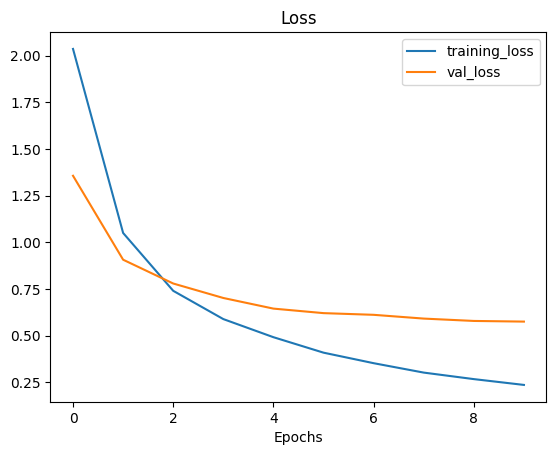

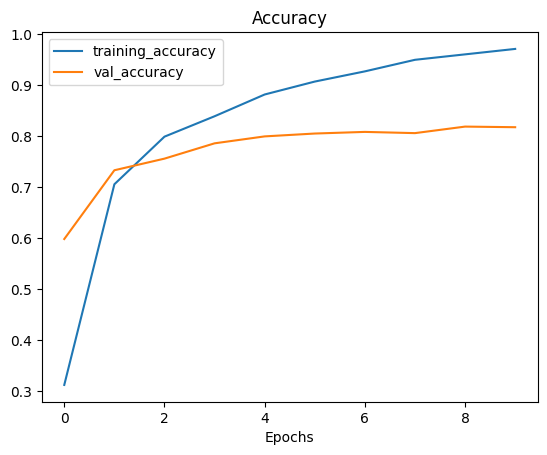

In [ ]:
plot_loss_curves(mobnet_history)

In [ ]:
# Get data (pizza_steak)
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile("pizza_steak.zip")
zip_ref.extractall()
zip_ref.close()

--2024-08-03 07:36:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.0.91, 172.217.7.59, 172.217.12.27, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.0.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip’

pizza_steak.zip     100%[===================>] 104.47M   277MB/s    in 0.4s    

2024-08-03 07:36:25 (277 MB/s) - ‘pizza_steak.zip’ saved [109540975/109540975]



In [ ]:
import os
# Walk through the pizza_steak directory and list the number of files
for dirpath, dirnames, filenames in os.walk("pizza_steak"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'pizza_steak'.
There are 2 directories and 0 images in 'pizza_steak/train'.
There are 0 directories and 750 images in 'pizza_steak/train/steak'.
There are 0 directories and 750 images in 'pizza_steak/train/pizza'.
There are 2 directories and 0 images in 'pizza_steak/test'.
There are 0 directories and 250 images in 'pizza_steak/test/steak'.
There are 0 directories and 250 images in 'pizza_steak/test/pizza'.


In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/pizza_steak/train/"
test_dir = "/content/pizza_steak/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary")

Training images:
Found 1500 images belonging to 2 classes.
Testing images:
Found 500 images belonging to 2 classes.


In [ ]:
# Download the pretrained model and save it as a Keras layer
feature_extractor_layer = hub.KerasLayer(efficientnet_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

# Create our own model
effnet_model_2 = tf.keras.Sequential([
  feature_extractor_layer, # use the feature extraction layer as the base
  layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer
])

In [ ]:
effnet_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 1280)              4049564   
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 1)                 1281      
                                                                 
Total params: 4050845 (15.45 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 4049564 (15.45 MB)
_________________________________________________________________


In [ ]:
# Compile the model
effnet_model_2.compile(loss='binary_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=['accuracy'])

In [ ]:
# Fit the model
effnet_history_2 = effnet_model_2.fit(train_data,
                                      epochs=5,
                                      steps_per_epoch=len(train_data),
                                      validation_data=test_data,
                                      validation_steps=len(test_data),
                                      callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                             experiment_name="effnetB0_pizza_steak"
                                                                             )])

Saving TensorBoard log files to: tensorflow_hub/effnetB0_pizza_steak/20240803-074413
Epoch 1/5
47/47 [==============================] - 145s 3s/step - loss: 0.2925 - accuracy: 0.9300 - val_loss: 0.1005 - val_accuracy: 0.9960
Epoch 2/5
47/47 [==============================] - 132s 3s/step - loss: 0.1213 - accuracy: 0.9733 - val_loss: 0.0578 - val_accuracy: 0.9960
Epoch 3/5
47/47 [==============================] - 139s 3s/step - loss: 0.0900 - accuracy: 0.9767 - val_loss: 0.0437 - val_accuracy: 0.9960
Epoch 4/5
47/47 [==============================] - 139s 3s/step - loss: 0.0738 - accuracy: 0.9813 - val_loss: 0.0363 - val_accuracy: 0.9960
Epoch 5/5
47/47 [==============================] - 130s 3s/step - loss: 0.0639 - accuracy: 0.9800 - val_loss: 0.0318 - val_accuracy: 0.9960


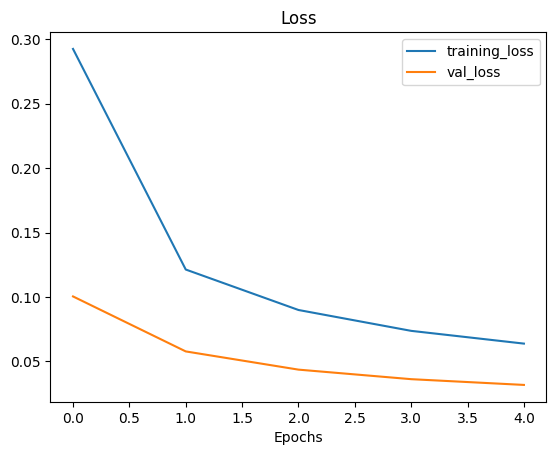

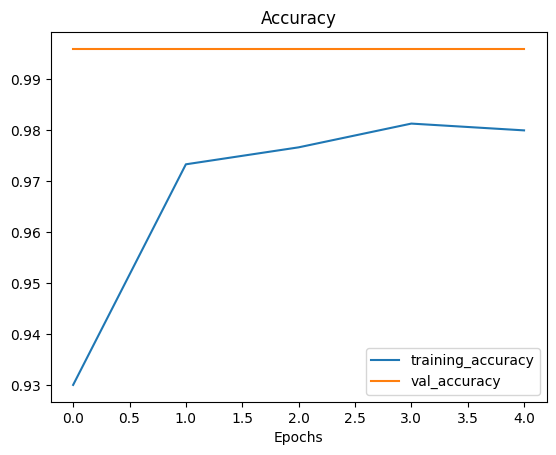

In [ ]:
 plot_loss_curves(effnet_history_2)

In [ ]:
class_names = ["pizza", "steak"]
class_names

['pizza', 'steak']

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_pred_image(filename, img_shape=224):
  """
  Reads an image form filename and turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image and get all values beween 0 and 1]
  img = img/255.
  return img

In [ ]:
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_pred_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 1s 1s/step


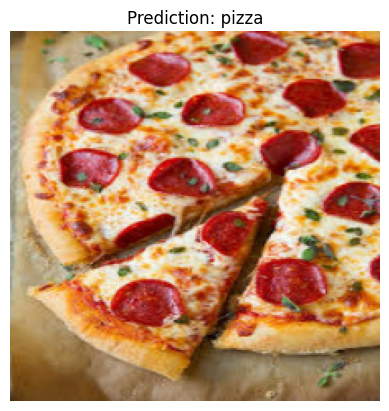

In [ ]:
pred_and_plot(effnet_model_2, "pizza-sample.jpeg")

1/1 [==============================] - 0s 113ms/step


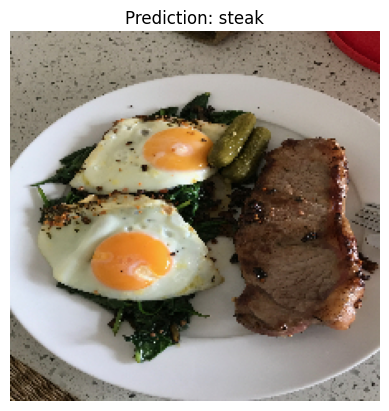

In [ ]:
pred_and_plot(effnet_model_2, "03-steak.jpeg")

1/1 [==============================] - 0s 72ms/step


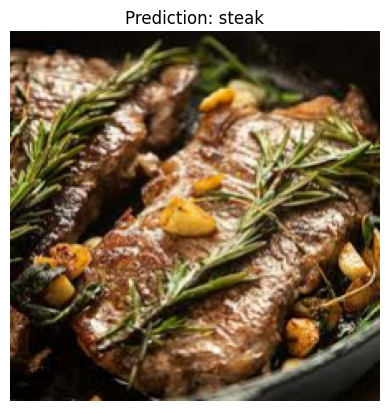

In [ ]:
pred_and_plot(effnet_model_2, "ss2.jpeg")

1/1 [==============================] - 0s 82ms/step


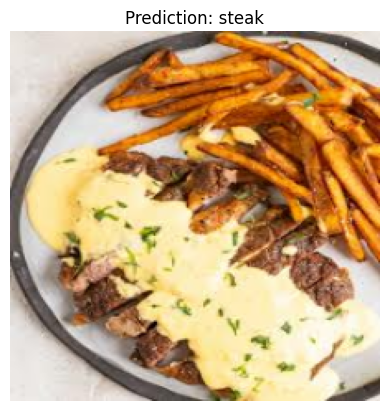

In [ ]:
pred_and_plot(effnet_model_2, "ss3.jpeg")

1/1 [==============================] - 0s 74ms/step


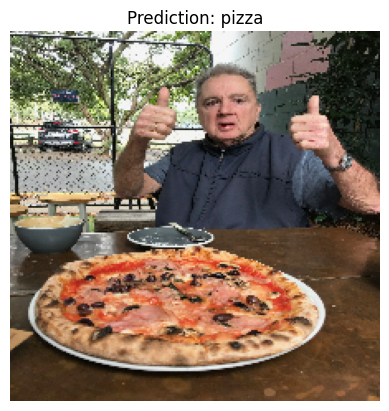

In [ ]:
pred_and_plot(effnet_model_2, "03-pizza-dad.jpeg")

## OUR MODEL WORKSSSSSSSSSSSSS !!!!!!!!!!!!!